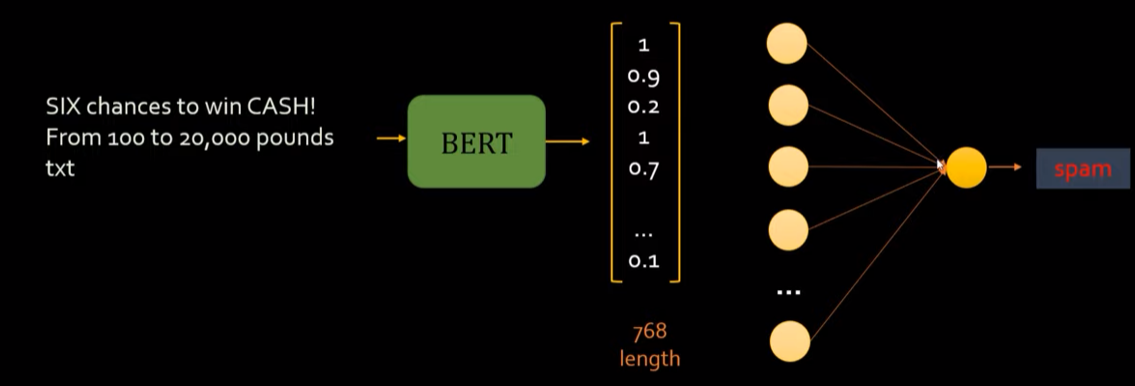

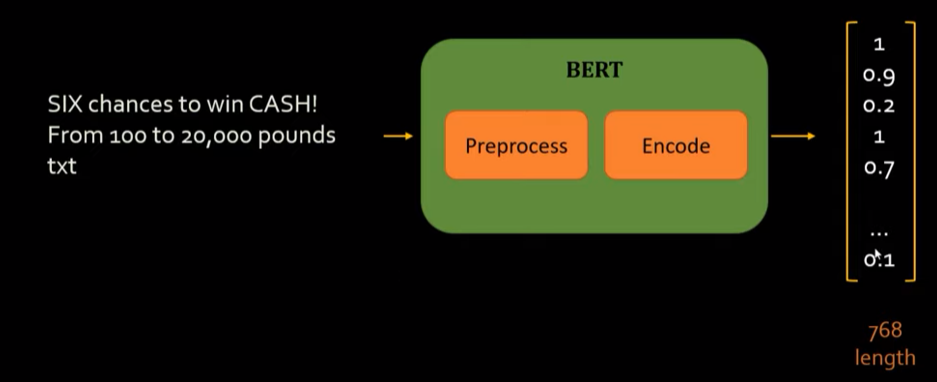

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text


In [9]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [11]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [12]:
747/4825

0.15481865284974095

In [13]:
df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [14]:
df_ham= df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [16]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [19]:
df_balanced=pd.concat([df_spam, df_ham_downsampled])
df.shape

(5572, 2)

In [20]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [21]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
2457,ham,Onum ela pa. Normal than.,0
4236,spam,FREEMSG: Our records indicate you may be entit...,1
2423,ham,A bloo bloo bloo I'll miss the first bowl,0
1880,spam,U have a secret admirer who is looking 2 make ...,1
4185,ham,I just really need shit before tomorrow and I ...,0


## Split it into training and test data set

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [23]:
X_train.head()

446     Sorry, my battery died, I can come by but I'm ...
3066                          Sounds good, keep me posted
2312    Congratulations! Thanks to a good friend U hav...
4665                      Mum not going robinson already.
1017    FREE for 1st week! No1 Nokia tone 4 ur mob eve...
Name: Message, dtype: object

## Now lets import BERT model and get embeding vectors for few sample statements

In [24]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [26]:
def get_sentence_embeding(sentences):
    preprocessed_text= bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)


<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.5132728 , -0.8884573 , ..., -0.74748874,
        -0.7531475 ,  0.9196451 ],
       [-0.8720836 , -0.50543994, -0.9444668 , ..., -0.858475  ,
        -0.71745366,  0.88082975]], dtype=float32)>

## Get embeding vectors for few sample words. Compare them using cosine similarity

In [27]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.99110866]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [29]:
cosine_similarity([e[0]],[e[3]])

array([[0.8470383]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [30]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872035]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

## Build Model

There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [33]:
# bert layers

text_input=tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")

preprocessed_text= bert_preprocess(text_input)

outputs=bert_encoder(preprocessed_text)



In [38]:
# neural network layers
l = tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)



In [40]:
# construct final model

model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [41]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [42]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)

In [45]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 43s 832ms/step - loss: 0.6305 - accuracy: 0.6509 - precision: 0.6603 - recall: 0.6214
Epoch 2/10
35/35 [==============================] - 23s 656ms/step - loss: 0.5056 - accuracy: 0.8214 - precision: 0.7885 - recall: 0.8786
Epoch 3/10
35/35 [==============================] - 21s 613ms/step - loss: 0.4455 - accuracy: 0.8518 - precision: 0.8530 - recall: 0.8500
Epoch 4/10
35/35 [==============================] - 21s 614ms/step - loss: 0.4046 - accuracy: 0.8580 - precision: 0.8347 - recall: 0.8929
Epoch 5/10
35/35 [==============================] - 22s 615ms/step - loss: 0.3732 - accuracy: 0.8687 - precision: 0.8530 - recall: 0.8911
Epoch 6/10
35/35 [==============================] - 21s 611ms/step - loss: 0.3469 - accuracy: 0.8848 - precision: 0.8787 - recall: 0.8929
Epoch 7/10
35/35 [==============================] - 21s 612ms/step - loss: 0.3251 - accuracy: 0.8848 - precision: 0.8787 - recall: 0.8929
Epoch 8/10
35/35 [================

In [46]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 9s 594ms/step - loss: 0.2695 - accuracy: 0.9171 - precision: 0.9105 - recall: 0.9251


[0.26950937509536743,
 0.9171122908592224,
 0.9105263352394104,
 0.9251337051391602]

In [47]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 8s 605ms/step


In [48]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,

In [49]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[170,  17],
       [ 14, 173]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

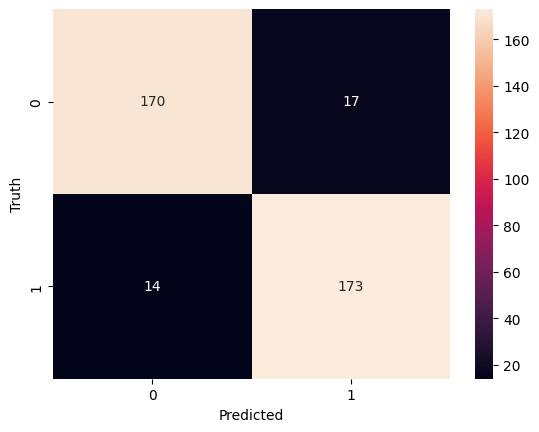

In [50]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [51]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       187
           1       0.91      0.93      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



## Inference

In [52]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 949ms/step


array([[0.7270527 ],
       [0.8067534 ],
       [0.78418785],
       [0.23782955],
       [0.09932733]], dtype=float32)

Exercise bert example in tensorflow 